In [33]:
!pip install gymnasium
!pip install gymnasium[classic-control]
!pip install gymnasium[other]
!pip install IPython

/bin/bash: warning: setlocale: LC_ALL: cannot change locale (en_US.UTF-8)
/bin/bash: warning: setlocale: LC_ALL: cannot change locale (en_US.UTF-8)
/bin/bash: warning: setlocale: LC_ALL: cannot change locale (en_US.UTF-8)
/bin/bash: warning: setlocale: LC_ALL: cannot change locale (en_US.UTF-8)


In [34]:
import gymnasium as gym
from gymnasium.wrappers import RecordVideo
import glob
import io
import base64
from IPython.display import HTML
from IPython import display as ipythondisplay

def show_video_html():
  mp4list = glob.glob('videos/*.mp4')
  if len(mp4list) > 0:
    mp4 = mp4list[0]
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video).decode('ascii')
    ipythondisplay.display(HTML(data='<video controls src="data:video/x-m4v;base64,{0}">'.format(encoded)))
  else:
    print("Could not find video")

In [35]:
class Agent:

    def __init__(self):
        self.cumulative_reward = 0

    def step(self, action_space, observation):
        pass

    def reward(self, immediate_reward, prev_action, prev_observation, new_observation):
        self.cumulative_reward += immediate_reward

    def reset(self):
        print("Cumulative reward for this round:", self.cumulative_reward)
        self.cumulative_reward = 0


def run_episode(agent: Agent, show_video=False):
    env = RecordVideo(gym.make("CartPole-v1", render_mode="rgb_array"), "./videos")
    observation, info = env.reset()
    cumulative_reward = 0
    while True:
        action = agent.step(env.action_space, observation)
        new_observation, reward, terminated, truncated, info  = env.step(action)
        agent.reward(reward, action, observation, new_observation)
        observation = new_observation
        if terminated or truncated:
            observation, info = env.reset()
            cumulative_reward += agent.cumulative_reward
            agent.reset()
            break
    if show_video:
        show_video_html()
    return cumulative_reward


In [36]:
import matplotlib.pyplot as plt

class RandomAgent(Agent):
    def step(self, action_space, observation):
        return action_space.sample()

episode_results = []
random_agent = RandomAgent()
for i in range(100):
    episode_results.append(run_episode(random_agent))



Cumulative reward for this round: 38.0
Cumulative reward for this round: 53.0
Cumulative reward for this round: 43.0
Cumulative reward for this round: 18.0
Cumulative reward for this round: 50.0
Cumulative reward for this round: 38.0
Cumulative reward for this round: 44.0
Cumulative reward for this round: 48.0
Cumulative reward for this round: 24.0
Cumulative reward for this round: 21.0
Cumulative reward for this round: 20.0
Cumulative reward for this round: 9.0
Cumulative reward for this round: 22.0
Cumulative reward for this round: 22.0
Cumulative reward for this round: 21.0
Cumulative reward for this round: 40.0
Cumulative reward for this round: 13.0
Cumulative reward for this round: 17.0
Cumulative reward for this round: 12.0
Cumulative reward for this round: 11.0
Cumulative reward for this round: 11.0
Cumulative reward for this round: 15.0
Cumulative reward for this round: 33.0
Cumulative reward for this round: 15.0
Cumulative reward for this round: 20.0
Cumulative reward for this

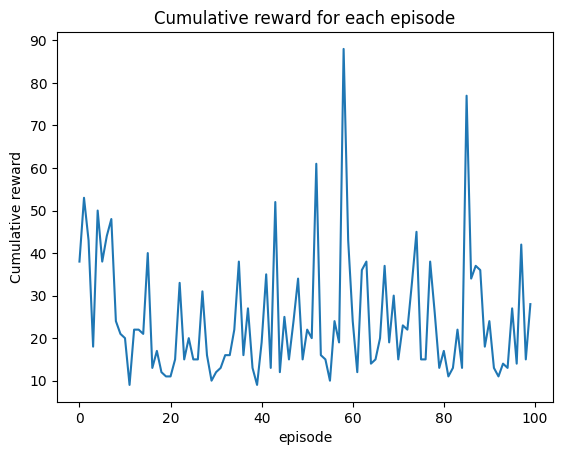

In [37]:
def show_result(episode_results):
    plt.plot(episode_results)
    plt.title('Cumulative reward for each episode')
    plt.ylabel('Cumulative reward')
    plt.xlabel('episode')
    plt.show()

show_result(episode_results)


Cumulative reward for this round: 23.0
Cumulative reward for this round: 10.0
Cumulative reward for this round: 10.0
Cumulative reward for this round: 16.0
Cumulative reward for this round: 15.0
Cumulative reward for this round: 28.0
Cumulative reward for this round: 21.0
Cumulative reward for this round: 24.0
Cumulative reward for this round: 14.0
Cumulative reward for this round: 19.0
Cumulative reward for this round: 21.0
Cumulative reward for this round: 12.0
Cumulative reward for this round: 24.0
Cumulative reward for this round: 31.0
Cumulative reward for this round: 17.0
Cumulative reward for this round: 30.0
Cumulative reward for this round: 21.0
Cumulative reward for this round: 28.0
Cumulative reward for this round: 31.0
Cumulative reward for this round: 50.0
Cumulative reward for this round: 40.0
Cumulative reward for this round: 10.0
Cumulative reward for this round: 42.0
Cumulative reward for this round: 12.0
Cumulative reward for this round: 13.0
Cumulative reward for thi

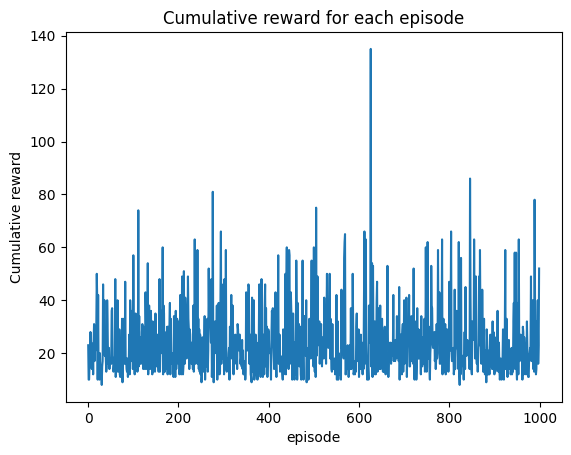

In [45]:
import numpy as np


def to_discrete_state(observation):
    np_array_win_size = np.array([0.25, 0.25, 0.01, 0.1])
    discrete_state = observation/np_array_win_size+ np.array([15,10,1,10], dtype=np.int64)
    return tuple(discrete_state.astype(np.int64))

# Model free
class QLearningControlAgent(Agent):

    def __init__(self, epsilon=0.2, discount_factor=0.9, learning_rate=0.1, qtable_size=()):
        super().__init__()
        self.epsilon = epsilon
        self.discount_factor = discount_factor
        self.learning_rate = learning_rate
        self.qtable = np.random.uniform(low=0, high=1, size=qtable_size)

    def step(self, action_space, observation):
        state = to_discrete_state(observation)
        # epsilon-greedy policy
        if np.random.random() < self.epsilon:
            action = np.argmax(self.qtable[state])
        else:
            action = np.random.randint(0, action_space.n)
        self.epsilon = self.epsilon ** 0.9995 # decay to statisfy GLIE
        return action

    def reward(self, immediate_reward, prev_action, prev_observation, new_observation):
        super().reward(immediate_reward, prev_action, prev_observation, new_observation)
        prev_state = to_discrete_state(prev_observation)
        new_state = to_discrete_state(new_observation)
        self.qtable[prev_state + (prev_action,)] += self.learning_rate * (immediate_reward + self.discount_factor * np.max(self.qtable[new_state]) - self.qtable[prev_state + (prev_action,)])

episode_results = []
qlearning_agent = QLearningControlAgent(qtable_size=([30, 30, 50, 50] + [2]))
for i in range(1000):
    episode_results.append(run_episode(qlearning_agent))

show_result(episode_results)